## Goals

  * XXX Implement the escape the world environment using a class similar to the openai gym world
  
  
  * Implement the following algorithms (and ensure these work for the environment with random values)
    * XXX policy evaluation
    * XXX policy iteration
    * XXX value iteration
    

  * Create 3 reward functions:
    * XXX -1 for each step
    * XXX +50 for any action that takes us to state 18, -1 for all other transitions
    * XXX function that increases as we get closer to state 18
      * This can be simple for now as in -1 for all states in the first sink, 1 along the chain, 5 in the new sink, and 10 if state 18
    

  * Design experiments for each algorithm after ensuring it works and visualize results.
    * Vary the discount factor in .1 increments from .1 to 1. Create a color plot where the x axis is the discount factor, the y axis is the state, and the color is the value returned from the value function.
    
    * Pick a discount factor a

In [8]:
import itertools
from time import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import seaborn as sns

import utils

%matplotlib inline
sns.set()

In [2]:
def simple_reward(s, a, s_p):
    '''-1 reward for each transition'''
    return -1

def end_goal_reward(s, a, s_p):
    '''+50 for any action that takes us to state 18, -1 for all other transitions'''
    if s_p == 18:
        return 50
    return -1

def distance_reward(s, a, s_p):
    '''reward increases as we get closer to state 18.
    1 along the chain, 5 in the new sink, and 10 if state 18'''
    reward = {}
    for i in range(19):
        if i <= 9:
            reward[i] = -1
        elif i > 9 and i <= 14:
            reward[i] = 1
        elif i > 14 and i < 18:
            reward[i] = 5
        elif i == 18:
            reward[i] = 10
            
    return reward[s_p]


class EscapeTheRoom():
    
    states = [i for i in range(19)]
    actions = [i for i in range(3)]
    
    def __init__(self, alpha, beta, reward_func, model_string=utils.model_line):
        
        self.reward_func = reward_func
        self.model_string = model_string
        
        self.nS = len(self.states)
        self.nA = len(self.actions)
        
        self.P = self.get_transition_model(alpha, beta)
        
        
    def get_transition_model(self, alpha, beta):
        """
        Returns a list of tuples where each tuple contains
        (state s, action a, state s', Pr(s_{t+1}=s' | s_t = s, a_t = a))

        Runs test to ensure the probabilities are valid.
        """
        P = {}
        
        for s in self.states:
            P[s] = {a : [] for a in range(self.nA)}
            
        S = self.states
        A = self.actions
        
        for line in self.model_string.split('\n'):
            if line == '':
                continue

            split_line = line.split(',')


            s = int(split_line[0][split_line[0].find('[')+1: split_line[0].find(']')])
            a = int(split_line[1][split_line[1].find('[')+1: split_line[1].find(']')])
            s_p = int(split_line[2][split_line[2].find('[')+1: split_line[2].find(']')])

            prob = split_line[3].strip()
            prob = eval(prob[:prob.find(')')])
            
            reward = self.reward_func(s, a, s_p)
            
            # prob, next_state, reward, done
            P[s][a].append((prob, s_p, reward, False))
        
        return P        


alpha = .3
beta = .5

env = EscapeTheRoom(alpha, beta, simple_reward)

print('States', env.states)
print('Number of states', env.nS)
print('Actions', env.actions)
print('Number of actions',env.nA)
print('Model', env.P)

States [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
Number of states 19
Actions [0, 1, 2]
Number of actions 3
Model {0: {0: [(1, 0, -1, False)], 1: [(0.3, 1, -1, False), (0.7, 2, -1, False)], 2: [(0.5, 2, -1, False), (0.5, 3, -1, False)]}, 1: {0: [(1, 0, -1, False)], 1: [(0.3, 2, -1, False), (0.7, 3, -1, False)], 2: [(0.5, 5, -1, False), (0.5, 6, -1, False)]}, 2: {0: [(1, 0, -1, False)], 1: [(0.3, 1, -1, False), (0.7, 3, -1, False)], 2: [(0.5, 7, -1, False), (0.5, 8, -1, False)]}, 3: {0: [(1, 0, -1, False)], 1: [(0.3, 1, -1, False), (0.7, 2, -1, False)], 2: [(0.5, 4, -1, False), (0.5, 9, -1, False)]}, 4: {0: [(1, 3, -1, False)], 1: [(0.3, 5, -1, False), (0.7, 6, -1, False)], 2: [(0.5, 8, -1, False), (0.5, 9, -1, False)]}, 5: {0: [(1, 1, -1, False)], 1: [(0.3, 6, -1, False), (0.7, 7, -1, False)], 2: [(0.5, 4, -1, False), (0.5, 9, -1, False)]}, 6: {0: [(1, 1, -1, False)], 1: [(0.3, 7, -1, False), (0.7, 8, -1, False)], 2: [(0.5, 4, -1, False), (0.5, 5, -1, False)]}, 

In [3]:
MAX_ITERS = 10000

def policy_eval(policy, env, discount_factor=1.0, theta=0.00001):
    """
    Evaluate a policy given an environment and a full description of the environment's dynamics.
    
    Args:
        policy: [S, A] shaped matrix representing the policy.
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a (prob, next_state, reward, done) tuple.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: lambda discount factor.
    
    Returns:
        Vector of length env.nS representing the value function.
    """
    # Start with a random (all 0) value function
    V = np.zeros(env.nS)
    num_iters = 0
    while True and num_iters < MAX_ITERS:
        delta = 0
        # For each state, perform a "full backup"
        for s in range(env.nS):
            v = 0
            # Look at the possible next actions
            for a, action_prob in enumerate(policy[s]):
                # For each action, look at the possible next states...
                for  prob, next_state, reward, done in env.P[s][a]:
                    # Calculate the expected value
                    v += action_prob * prob * (reward + discount_factor * V[next_state])
            # How much our value function changed (across any states)
            delta = max(delta, np.abs(v - V[s]))
            V[s] = v
        # Stop evaluating once our value function change is below a threshold
        if delta < theta:
            break
        num_iters += 1
    return np.array(V)

# test policy evaluation
env = EscapeTheRoom(alpha, beta, simple_reward)
random_policy = np.ones([env.nS, env.nA]) / env.nA
v = policy_eval(random_policy, env, discount_factor=1)
print(v)

[-18789.53475198 -18790.50154345 -18790.82049337 -18791.14387539
 -18791.51820407 -18791.56703047 -18791.79565643 -18792.04052389
 -18792.29973476 -18792.58425337 -18793.6924325  -18794.73386413
 -18795.67517452 -18796.46630304 -18797.03215876 -18796.99911041
 -18797.14744524 -18797.62549806 -18797.57605311]


# Experiment 1

For each reward function, vary the discount factor linearly from .1 to 1 and analyze the value functions returned.

In [4]:
t0 = time()

reward_funcs = {'simple': simple_reward, 'end_goal_reward': end_goal_reward, 'distance': distance_reward}

lambdas = np.linspace(.1, 1, 10)

value_functions_exp01 = {}

for label, reward_func in reward_funcs.items():
    
    value_functions_exp01[label] = {}
    
    for l in lambdas:
        env = EscapeTheRoom(alpha, beta, reward_func)
        random_policy = np.ones([env.nS, env.nA]) / env.nA
        v = policy_eval(random_policy, env, discount_factor=l)
        value_functions_exp01[label][l] = v
    
t1 = time()

print('Experiment 1 time to run: {} seconds'.format(t1-t0))

Experiment 1 time to run: 4.331560850143433 seconds


## Plot 1

For each reward function, plot the mean of the value function returned from policy evaluation for each value of the discount factor.

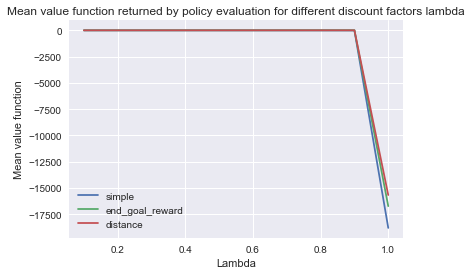

In [36]:
for label in value_functions_exp01:
    x = sorted(value_functions_exp01[label].keys())
    y = [np.mean(value_functions_exp01[label][k]) for k in x]
    
    plt.plot(x, y, label=label)
    
plt.title('Mean value function returned by policy evaluation for different discount factors lambda')

plt.xlabel('Lambda')
plt.ylabel('Mean value function')
plt.legend()
plt.show()

## Plot 2

For each reward function, create a 3d plot with 
  * x-axis = discount factor
  * y-axis = state (0-18)
  * z-axis = value(state)
  
Exclude $\lambda = 1$ for all reward functions becsause it throws off the visuals

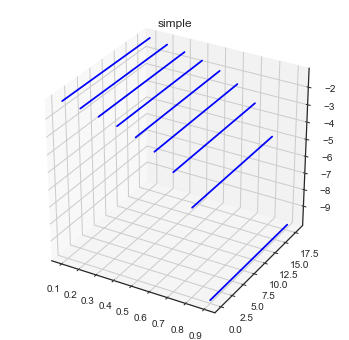

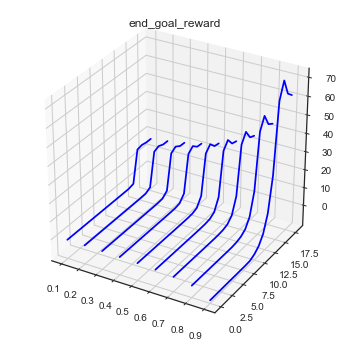

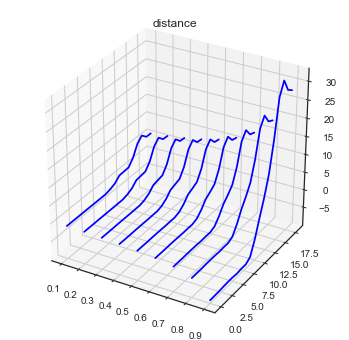

In [88]:
sns.set(style='white')

for i, label in enumerate(value_functions_exp01.keys()):
    
    fig = plt.figure(figsize=(6, 6))
    
    ax = fig.add_subplot('111'.format(i+1), projection='3d')
    ax.set_title(label)
    
    for discount in value_functions_exp01[label]:
        
        if discount == 1:
            continue
            
        value_function = value_functions_exp01[label][discount]
        
        x = [discount for _ in range(19)]
        y = [i for i in range(len(value_function))]
        
        ax.plot(x, y, value_function, c='blue')

## Plot 3

Since we excluded $\lambda=1$ in the above plots, create a line plot for each of the reward functions and $\lambda=1$ here.

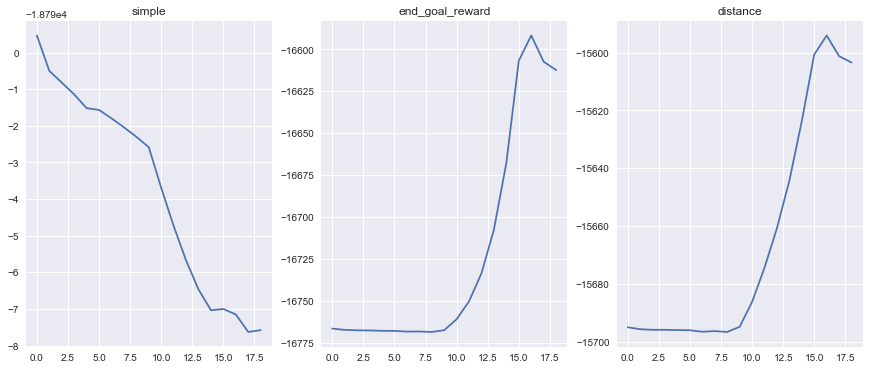

In [100]:
sns.set()

fig = plt.figure(figsize=(15, 6))

for i, label in enumerate(value_functions_exp01.keys()):
    
    ax = fig.add_subplot('13{}'.format(i+1))
    ax.set_title(label)
            
    value_function = value_functions_exp01[label][1.0]

    ax.plot(value_function)

## Experiment 2

For each reward function, vary the discount factor linearly from .9 to 1 by .01 and analyze the value functions returned.

In [6]:
t0 = time()

reward_funcs = {'simple': simple_reward, 'end_goal_reward': end_goal_reward, 'distance': distance_reward}

lambdas = np.linspace(.9, 1, 101)

value_functions_exp02 = {}

for label, reward_func in reward_funcs.items():
    
    value_functions_exp02[label] = {}
    
    for l in lambdas:
        env = EscapeTheRoom(alpha, beta, reward_func)
        random_policy = np.ones([env.nS, env.nA]) / env.nA
        v = policy_eval(random_policy, env, discount_factor=l)
        value_functions_exp02[label][l] = v
    
t1 = time()

print('Experiment 1 time to run: {} seconds'.format(t1-t0))

Experiment 1 time to run: 17.978957176208496 seconds


## Plot 1

For each reward function, plot the mean of the value function returned from policy evaluation for each value of the discount factor.

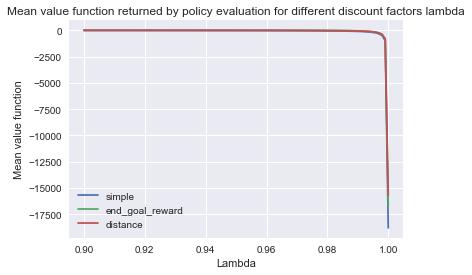

In [40]:
for label in value_functions_exp01:
    x = sorted(value_functions_exp02[label].keys())
    y = [np.mean(value_functions_exp02[label][k]) for k in x]
    
    plt.plot(x, y, label=label)
    
plt.title('Mean value function returned by policy evaluation for different discount factors lambda')

plt.xlabel('Lambda')
plt.ylabel('Mean value function')
plt.legend()
plt.show()

Lets ignore the lambda = 1 here

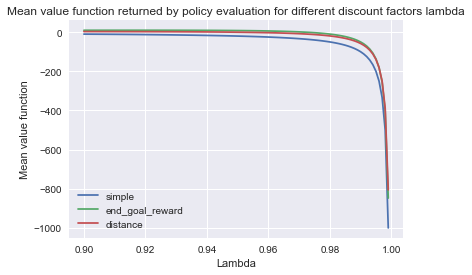

In [42]:
for label in value_functions_exp01:
    x = sorted(value_functions_exp02[label].keys())
    y = [np.mean(value_functions_exp02[label][k]) for k in x]
    
    plt.plot(x[:-1], y[:-1], label=label)
    
plt.title('Mean value function returned by policy evaluation for different discount factors lambda')

plt.xlabel('Lambda')
plt.ylabel('Mean value function')
plt.legend()
plt.show()

## Plot 2

For each reward function, create a 3d plot with 
  * x-axis = discount factor
  * y-axis = state (0-18)
  * z-axis = value(state)
  
Exclude $\lambda = 1$ for all reward functions becsause it throws off the visuals

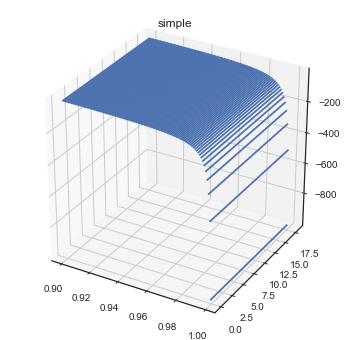

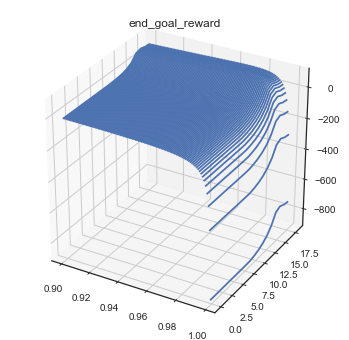

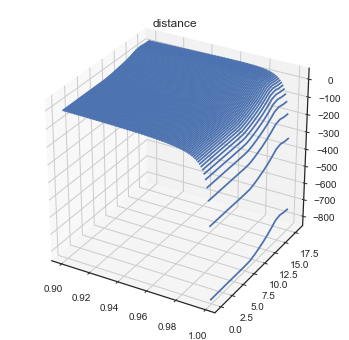

In [103]:
sns.set(style='white')

for i, label in enumerate(value_functions_exp02.keys()):
    
    fig = plt.figure(figsize=(6, 6))
    
    ax = fig.add_subplot('111'.format(i+1), projection='3d')
    ax.set_title(label)
    
    for discount in value_functions_exp02[label]:
        
        if discount == 1:
            continue
            
        value_function = value_functions_exp02[label][discount]
        
        x = [discount for _ in range(19)]
        y = [i for i in range(len(value_function))]
        
        ax.plot_wireframe(x, y, value_function)#, c='blue')

## Plot 3

Since we excluded $\lambda=1$ in the above plots, create a line plot for each of the reward functions and $\lambda=1$ here.

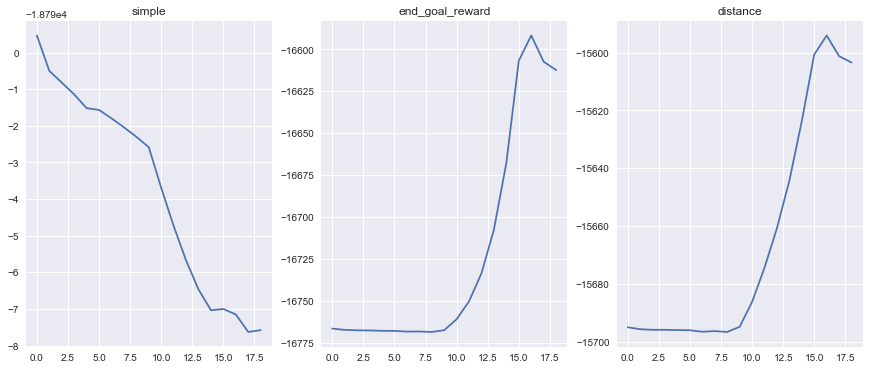

In [7]:
sns.set()

fig = plt.figure(figsize=(15, 6))

for i, label in enumerate(value_functions_exp02.keys()):
    
    ax = fig.add_subplot('13{}'.format(i+1))
    ax.set_title(label)
            
    value_function = value_functions_exp02[label][1.0]

    ax.plot(value_function)

# Experiment 3

Run policy evaluation for different values of $\alpha$ and $\beta$ parameters. That is, vary alpha and beta linearly between .1 to 1, run policy evaluation with each reward function.

Set the discount factor $\lambda=.9$ .

In [43]:
t0 = time()

reward_funcs = {'simple': simple_reward, 'end_goal_reward': end_goal_reward, 'distance': distance_reward}

discount_rate = .9

value_functions_exp03 = {}

for label, reward_func in reward_funcs.items():
    
    value_functions_exp03[label] = []
    
    for alpha, beta in  itertools.product(np.linspace(.1, 1, 10), repeat=2):

        env = EscapeTheRoom(alpha, beta, reward_func)
        random_policy = np.ones([env.nS, env.nA]) / env.nA
        v = policy_eval(random_policy, env, discount_factor=discount_rate)
        # store tuples of (alpha, beta, value function)
        value_functions_exp03[label].append((alpha, beta, v))
    
t1 = time()

print('Experiment 3 time to run: {} seconds'.format(t1-t0))

Experiment 3 time to run: 2.9450340270996094 seconds


# Plot 1

For each reward function, plot a 3-d plot of (x,y,z) = (alpha, beta, mean value function)

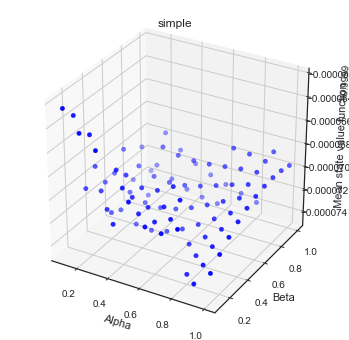

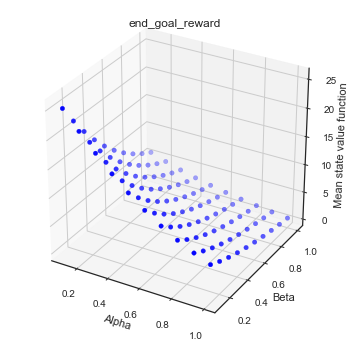

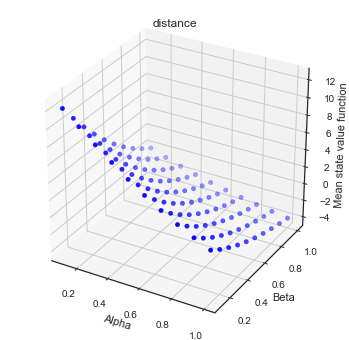

In [44]:
sns.set(style='white')

for i, label in enumerate(value_functions_exp03.keys()):
    
    x = [t[0] for t in value_functions_exp03[label]]
    y = [t[1] for t in value_functions_exp03[label]]
    z = [np.mean(t[2]) for t in value_functions_exp03[label]]

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot('111'.format(i+1), projection='3d')
    ax.scatter(x, y, z, c='blue')
    
    ax.set_title(label)
    ax.set_xlabel('Alpha')
    ax.set_ylabel('Beta')
    ax.set_zlabel('Mean state value function')


plt.show()

# Plot 2

Hold $\beta$ fixed.  Plot a 3-d plot of (x,y,z) = (alpha, state, value function).

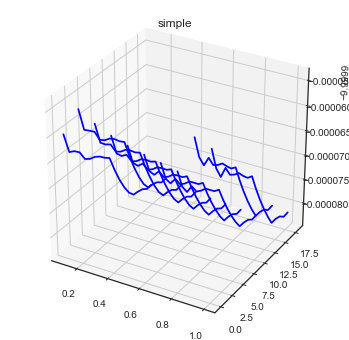

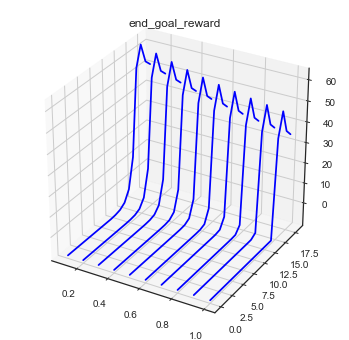

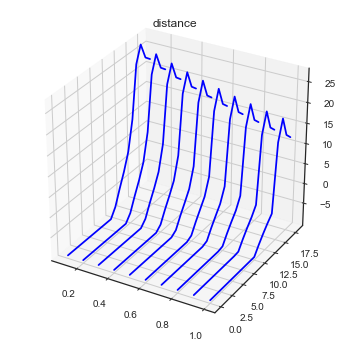

In [45]:
beta = 1

for i, label in enumerate(value_functions_exp03.keys()):
    
    exp_3_plot_2_data = [(t[0], t[2]) for t in value_functions_exp03[label] if np.isclose(t[1],beta)]

    fig = plt.figure(figsize=(6, 6))
    
    ax = fig.add_subplot('111'.format(i+1), projection='3d')
    ax.set_title(label)

    for alpha, value_func in exp_3_plot_2_data:
        x = [alpha for _ in range(19)]
        y = [i for i in range(19)]
        z = value_func
        ax.plot(x, y, z, c='blue')
        
    plt.show()

In [49]:
def policy_improvement(env, policy_eval_fn=policy_eval, discount_factor=1.0):
    """
    Policy Improvement Algorithm. Iteratively evaluates and improves a policy
    until an optimal policy is found.
    
    Args:
        env: The OpenAI envrionment.
        policy_eval_fn: Policy Evaluation function that takes 3 arguments:
            policy, env, discount_factor.
        discount_factor: Lambda discount factor.
        
    Returns:
        A tuple (policy, V). 
        policy is the optimal policy, a matrix of shape [S, A] where each state s
        contains a valid probability distribution over actions.
        V is the value function for the optimal policy.
        
    """
    # Start with a random policy
    policy = np.ones([env.nS, env.nA]) / env.nA
    
    while True:
        # Evaluate the current policy
        V = policy_eval_fn(policy, env, discount_factor)
        
        # Will be set to false if we make any changes to the policy
        policy_stable = True
        
        # For each state...
        for s in range(env.nS):
            # The best action we would take under the currect policy
            chosen_a = np.argmax(policy[s])
            
            # Find the best action by one-step lookahead
            # Ties are resolved arbitarily
            action_values = np.zeros(env.nA)
            for a in range(env.nA):
                for prob, next_state, reward, done in env.P[s][a]:
                    action_values[a] += prob * (reward + discount_factor * V[next_state])
            best_a = np.argmax(action_values)
            
            # Greedily update the policy
            if chosen_a != best_a:
                policy_stable = False
            policy[s] = np.eye(env.nA)[best_a]
        
        # If the policy is stable we've found an optimal policy. Return it
        if policy_stable:
            return policy, V

In [86]:
env = EscapeTheRoom(alpha, beta, distance_reward)
policy, v = policy_improvement(env, discount_factor=.9)

print("Policy Probability Distribution $\pi(a|s)$:")
print(policy)
print("")

print("Value Function:")
print(v)
print("")

Policy Probability Distribution $\pi(a|s)$:
[[ 0.  0.  1.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]]

Value Function:
[ 15.08056131  15.50946824  16.67588745  19.05870386  19.05870466
  19.05870625  16.46666487  20.22105412  19.05870625  25.51620359
  37.64397473  48.18191132  58.75879818  71.03124946  85.9783799
  99.99991792  99.99991792  99.99991792  99.99991792]



In [54]:
def value_iteration(env, theta=0.0001, discount_factor=1.0):
    """
    Value Iteration Algorithm.
    
    Args:
        env: OpenAI environment. env.P represents the transition probabilities of the environment.
        theta: Stopping threshold. If the value of all states changes less than theta
            in one iteration we are done.
        discount_factor: lambda time discount factor.
        
    Returns:
        A tuple (policy, V) of the optimal policy and the optimal value function.
    """
    
    def one_step_lookahead(state, V):
        """
        Helper function to calculate the value for all action in a given state.
        
        Args:
            state: The state to consider (int)
            V: The value to use as an estimator, Vector of length env.nS
        
        Returns:
            A vector of length env.nA containing the expected value of each action.
        """
        A = np.zeros(env.nA)
        for a in range(env.nA):
            for prob, next_state, reward, done in env.P[state][a]:
                A[a] += prob * (reward + discount_factor * V[next_state])
        return A
    
    V = np.zeros(env.nS)
    num_iters = 0
    while True and num_iters < MAX_ITERS:
        # Stopping condition
        delta = 0
        # Update each state...
        for s in range(env.nS):
            # Do a one-step lookahead to find the best action
            A = one_step_lookahead(s, V)
            best_action_value = np.max(A)
            # Calculate delta across all states seen so far
            delta = max(delta, np.abs(best_action_value - V[s]))
            # Update the value function
            V[s] = best_action_value        
        # Check if we can stop 
        if delta < theta:
            break
        num_iters += 1
    
    # Create a deterministic policy using the optimal value function
    policy = np.zeros([env.nS, env.nA])
    for s in range(env.nS):
        # One step lookahead to find the best action for this state
        A = one_step_lookahead(s, V)
        best_action = np.argmax(A)
        # Always take the best action
        policy[s, best_action] = 1.0
    
    return policy, V

In [89]:
env = EscapeTheRoom(alpha, beta, distance_reward)
policy, v = value_iteration(env)

print("Policy Probability Distribution:")
print(policy)
print("")

print("Value Function:")
print(v)
print("")

Policy Probability Distribution:
[[ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]]

Value Function:
[ 149782.07786637  149792.22786637  149793.67786637  149802.47786637
  149804.97786637  149809.97786637  149806.47786637  149809.37786637
  149809.97786637  149831.97786637  149868.97786637  149899.26358065
  149925.81460106  149950.76503838  149975.02951151  149995.          150000.
  150005.          150000.        ]



In [90]:
env = EscapeTheRoom(alpha, beta, end_goal_reward)
policy, v = value_iteration(env)

print("Policy Probability Distribution:")
print(policy)
print("")

print("Value Function:")
print(v)
print("")

Policy Probability Distribution:
[[ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]]

Value Function:
[ 499248.26587335  499282.33254001  499285.53254001  499312.99920668
  499321.33254001  499337.99920668  499328.66587335  499335.06587335
  499337.99920668  499406.66587335  499527.33254001  499630.47539716
  499726.10805022  499818.52204439  499909.55661332  500000.          500000.
  500000.          500000.        ]

